In [130]:
%cd ..
%pip install factor_analyzer

from transferbench.benchmark_tools.report_helpers import collect_results
from transferbench.benchmark_tools.utils import get_run_list, get_config_from_run


/Users/fabiobrau


7153.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [131]:
run_list = get_run_list()
df_results = collect_results(download=False)

In [132]:
from pandas import DataFrame

raw_run_df = DataFrame([get_config_from_run(run) for run in run_list])
surr_cols = [col for col in raw_run_df.columns if "surrogate_model" in col]
completed_results = df_results.merge(raw_run_df.loc[:,["id",*surr_cols]], on="id", how="left")

In [133]:
completed_results.columns

Index(['predictions', 'labels', 'targets', 'success', 'queries', 'id',
       'status', 'attack', 'victim_model', 'campaign', 'p', 'eps',
       'maximum_queries', 'dataset', 'available', 'surrogate_model_0',
       'surrogate_model_1', 'surrogate_model_2', 'surrogate_model_3',
       'surrogate_model_4', 'surrogate_model_5'],
      dtype='object')

In [158]:
import pandas as pd

MODELS_CATEGORIES = {# To move into a config file
    "residuals": [
        'Amini2024MeanSparse_S-WRN-70-16',
        'Bartoldson2024Adversarial_WRN-94-16',
        'Wang2023Better_WRN-70-16',
        'cifar100_resnet20', 'cifar100_resnet32', 'cifar100_resnet44', 'cifar100_resnet56',
        'cifar10_resnet20', 'cifar10_resnet32', 'cifar10_resnet44', 'cifar10_resnet56',
        'imagenet_resnet50_pubdef',
        'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
        'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_64x4d',
        'wide_resnet50_2', 'wide_resnet101_2',
        'densenet121', 'densenet161', 'densenet169', 'densenet201',
         'cifar10_shufflenetv2_x0_5', 'cifar10_shufflenetv2_x1_0',
        'cifar10_shufflenetv2_x1_5', 'cifar10_shufflenetv2_x2_0',
        'cifar100_shufflenetv2_x0_5', 'cifar100_shufflenetv2_x1_0',
        'cifar100_shufflenetv2_x1_5', 'cifar100_shufflenetv2_x2_0',
        'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0',
    ],
    "cnn": [
        'alexnet', 'cifar100_mobilenetv2_x0_5', 'cifar100_mobilenetv2_x0_75',
        'cifar100_mobilenetv2_x1_0', 'cifar100_mobilenetv2_x1_4',
        'cifar100_repvgg_a0', 'cifar100_repvgg_a1', 'cifar100_repvgg_a2',
        'cifar100_vgg11_bn', 'cifar100_vgg13_bn', 'cifar100_vgg16_bn', 'cifar100_vgg19_bn',
        'cifar10_mobilenetv2_x0_5', 'cifar10_mobilenetv2_x0_75',
        'cifar10_mobilenetv2_x1_0', 'cifar10_mobilenetv2_x1_4',
        'cifar10_repvgg_a0', 'cifar10_repvgg_a1', 'cifar10_repvgg_a2',
        'cifar10_vgg11_bn', 'cifar10_vgg13_bn', 'cifar10_vgg16_bn', 'cifar10_vgg19_bn',
        'convnext_tiny', 'convnext_small', 'convnext_base', 'convnext_large',
        'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3',
        'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7',
        'efficientnet_v2_s', 'efficientnet_v2_m', 'efficientnet_v2_l',
        'googlenet', 'inception_v3',
        'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3',
        'mobilenet_v2', 'mobilenet_v3_small', 'mobilenet_v3_large',
        'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_1_6gf', 'regnet_x_3_2gf',
        'regnet_x_8gf', 'regnet_x_16gf', 'regnet_x_32gf',
        'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_1_6gf', 'regnet_y_3_2gf',
        'regnet_y_8gf', 'regnet_y_16gf', 'regnet_y_32gf', 'regnet_y_128gf',
        'squeezenet1_0', 'squeezenet1_1',
        'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'
    ],
    "transformer": [
        'Amini2024MeanSparse_Swin-L', 'Xu2024MIMIR_Swin-L',
        'cifar100_swin_b', 'cifar100_swin_t',
        'cifar10_beit_b16', 'cifar10_swin_b', 'cifar10_swin_t', 'cifar10_vit_b16',
        'maxvit_t',
        'swin_b', 'swin_s', 'swin_t', 'swin_v2_b', 'swin_v2_s', 'swin_v2_t',
        'vit_b_16', 'vit_b_32', 'vit_l_16', 'vit_l_32', 'vit_h_14'
    ]
}

FEATURES = [
    "res_victim", "cnn_victim", "vt_victim",
    "res_surr", "cnn_surr", "vt_surr",
    "attack", "campaign", "eps",
    "avg_success"]
def factor_analysis(df_results: pd.DataFrame) -> None:
    r"""Perform factor analysis on the results."""

    datasets = df_results["dataset"].unique()
    df_features = []
    # change null surrogate models to empty strings
    for col in df_results.columns:
        if "surrogate_model" in col:
            df_results[col] = df_results[col].fillna("")
    for dataset in datasets:
        df_loc = df_results[df_results["dataset"] == dataset]
        # Replace queries with nan when success is 0
        #df_loc.loc[df_loc["success"] == 0, "queries"] = float("nan")
        surr_cols = [col for col in df_loc.columns if "surrogate_model" in col]
        print(surr_cols)
        agg_df = df_loc.groupby(["attack", "campaign", "victim_model", *surr_cols, "eps"]).agg(
            avg_success=("success", "mean"),
            #avg_queries=("queries", "mean"),
            count=("success", "count"),
        )
        # Set queries to -1 when success is 0
        #agg_df.loc[agg_df["avg_success"] == 0, "avg_queries"] = -1
        agg_df = agg_df.reset_index()
        #agg_df.avg_success *= 100
        # Extract Features
        # Group victim models by categories
        agg_df["res_victim"] = agg_df["victim_model"].apply(
            lambda x: any(model in x for model in MODELS_CATEGORIES["residuals"])
        )
        agg_df["cnn_victim"] = agg_df["victim_model"].apply(
            lambda x: any(model in x for model in MODELS_CATEGORIES["cnn"])
        )
        agg_df["vt_victim"] = agg_df["victim_model"].apply(
            lambda x: any(model in x for model in MODELS_CATEGORIES["transformer"])
        )
        # GRoup surrogate models by categories
        agg_df["res_surr"] = 0
        agg_df["cnn_surr"] = 0
        agg_df["vt_surr"] = 0
        for i in range(6):
            agg_df["res_surr"] += agg_df[f"surrogate_model_{i}"].apply(
            lambda x: any(model in x for model in MODELS_CATEGORIES["residuals"])
            ).astype("int")
            agg_df["cnn_surr"] += agg_df[f"surrogate_model_{i}"].apply(
                lambda x: any(model in x for model in MODELS_CATEGORIES["cnn"])
            ).astype("int")
            agg_df["vt_surr"] += agg_df[f"surrogate_model_{i}"].apply(
                lambda x: any(model in x for model in MODELS_CATEGORIES["transformer"])
            ).astype("int")
        # Convert to binary
        agg_df["res_victim"] = agg_df["res_victim"].astype("int")
        agg_df["cnn_victim"] = agg_df["cnn_victim"].astype("int")
        agg_df["vt_victim"] = agg_df["vt_victim"].astype("int")
        
        agg_df["res_surr"] = agg_df["res_surr"].apply(lambda x: 1 if x > 0 else 0)
        agg_df["cnn_surr"] = agg_df["cnn_surr"].apply(lambda x: 1 if x > 0 else 0)
        agg_df["vt_surr"] = agg_df["vt_surr"].apply(lambda x: 1 if x > 0 else 0)

        agg_df = agg_df[FEATURES]
        agg_df = agg_df.rename(
            columns={"campaign": "scenario", "victim_model": "victim"})
        df_features.append(agg_df)
    return df_features


df_imagenet, df_cifar = factor_analysis(completed_results)

['surrogate_model_0', 'surrogate_model_1', 'surrogate_model_2', 'surrogate_model_3', 'surrogate_model_4', 'surrogate_model_5']
['surrogate_model_0', 'surrogate_model_1', 'surrogate_model_2', 'surrogate_model_3', 'surrogate_model_4', 'surrogate_model_5']


In [159]:
completed_results.campaign.unique(), df_imagenet.scenario.unique(), df_cifar.scenario.unique()


(array(['omeo', 'etero', 'robust'], dtype=object),
 array(['etero', 'omeo', 'robust'], dtype=object),
 array(['etero', 'omeo', 'robust'], dtype=object))

In [168]:

df = pd.concat([df_imagenet, df_cifar], ignore_index=True)
binary_vars = [
    "res_victim", "cnn_victim", "vt_victim",
    "res_surr", "cnn_surr", "vt_surr"]
cat_vars = ["attack", "scenario"]
numeric_vars = ["avg_success", "eps"]


# Encode categorical variables
df_enc_attack = pd.get_dummies(df["attack"].copy()).astype("int")
df_enc_scenario = pd.get_dummies(df["scenario"].copy()).astype("int")
print(f"Scenario columns: {df_enc_scenario.columns.tolist()}")
# Combine all variables for analysis
df_X = pd.concat([
    df[binary_vars],
    #df_enc_attack,
    df_enc_scenario,
    df[numeric_vars]
], axis=1)

Scenario columns: ['etero', 'omeo', 'robust']


Coefficients of the linear regression model:
res_victim: 0.1767
cnn_victim: 0.1302
vt_victim: -0.0789
res_surr: 0.0154
cnn_surr: 0.0088
vt_surr: 0.0146
etero: 0.0388
omeo: 0.2403
robust: -0.2791
eps: 0.0000


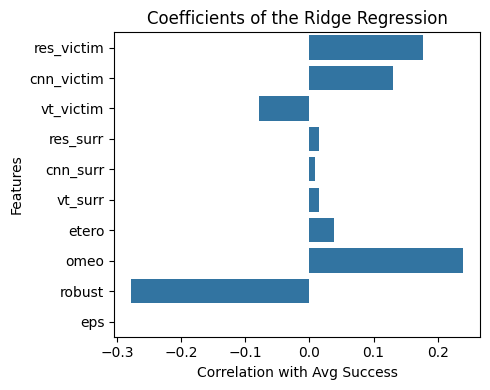

In [169]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
# Fit a linear regression model to check for multicollinearity

model = Ridge()
X = df_X.drop(columns=["avg_success"])  # Remove target variable for fitting
Y = df_X["avg_success"]
# Fit the model
model.fit(X, Y)
# Check the coefficients
coefficients = model.coef_
print("Coefficients of the linear regression model:")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef:.4f}")

# Barplot of coefficients
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5, 4))
sns.barplot(y=X.columns, x=coefficients, orient="h")
plt.title("Coefficients of the Ridge Regression")
plt.ylabel("Features")
plt.xlabel("Correlation with Avg Success")
plt.tight_layout()
plt.show()

In [170]:
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

kmo_all, kmo_model = calculate_kmo(df_X)
print(f"KMO Test Score: {kmo_model:.2f}")

chi_square_value, p_value = calculate_bartlett_sphericity(df_X)
print(f"Bartlett's test p-value: {p_value:.4f}")


KMO Test Score: nan
Bartlett's test p-value: nan


/opt/anaconda3/envs/TransfBench/lib/python3.13/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/opt/anaconda3/envs/TransfBench/lib/python3.13/site-packages/factor_analyzer/utils.py:199: RuntimeWarning: divide by zero encountered in divide
  Is = np.sqrt(1 / np.diag(m))
/opt/anaconda3/envs/TransfBench/lib/python3.13/site-packages/factor_analyzer/utils.py:200: RuntimeWarning: invalid value encountered in multiply
  retval = Is * m * np.repeat(Is, numrows).reshape(numrows, numrows)
/opt/anaconda3/envs/TransfBench/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
